<a href="https://colab.research.google.com/github/SafaSaifudeen/Medical_ASR/blob/main/baselineModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
!pip install datasets
!pip install Kaggle

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from jiwer import wer
import matplotlib.pyplot as plt
from IPython import display

In [6]:
wavs_paths = "/content/drive/MyDrive/dataset/LJSpeech-1.1/wavs/"
metadata_path =  "/content/drive/MyDrive/dataset/LJSpeech-1.1/metadata.csv"

In [7]:
metadata_df= pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [8]:
metadata_df.tail(10)

,0,1,2
13090,LJ050-0269,The essential terms of such memoranda might we...,The essential terms of such memoranda might we...
13091,LJ050-0270,This Commission can recommend no procedures fo...,This Commission can recommend no procedures fo...
13092,LJ050-0271,The demands on the President in the execution ...,The demands on the President in the execution ...
13093,LJ050-0272,and the traditions of the office in a democrac...,and the traditions of the office in a democrac...
13094,LJ050-0273,"The Commission has, however, from its examinat...","The Commission has, however, from its examinat..."
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [9]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ046-0014,at the time of President Kennedy's assassination.
1,LJ030-0008,"During the afternoon, President Kennedy dedica..."
2,LJ018-0192,"But they had the body, all the same; it had be..."


In [10]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [11]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz' "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)
print(f"The vocabulary = {char_to_num.get_vocabulary()} "
      f"(size ={char_to_num.vocabulary_size()})")

The vocabulary = ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_(' ')] (size =29)


In [12]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wavs_paths + "/" + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)


    #normalisation
    means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
    spectogram = (spectogram - means) / (stddevs + 1e-10)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return spectogram, label

In [13]:
batch_size =32
train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]), list(df_train["normalized_transcription"])))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((list(df_val["file_name"]), list(df_val["normalized_transcription"])))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

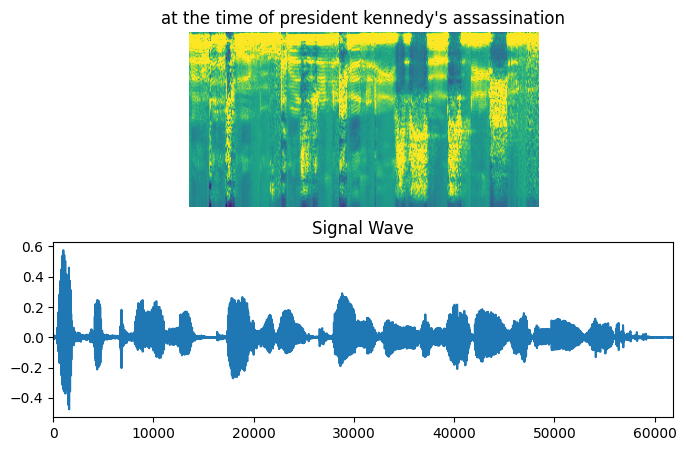

In [14]:
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    spectogram = batch[0][0].numpy()
    # Transpose the spectrogram before trimming zeros
    spectogram = np.transpose(spectogram)
    # Pad the trimmed spectrograms to ensure uniform length
    spectogram = [np.trim_zeros(x) for x in spectogram]
    max_len = max(len(row) for row in spectogram)
    spectogram = np.array([np.pad(row, (0, max_len - len(row)), 'constant') for row in spectogram])

    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2,1,1)
    ax.imshow(spectogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    file = tf.io.read_file(wavs_paths + df_train["file_name"][0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
    plt.show()

In [15]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast (tf.shape(y_true)[0], dtype = "int64")
  input_length = tf.cast (tf.shape(y_pred)[1], dtype = "int64")
  label_length = tf.cast (tf.shape(y_true)[1], dtype = "int64")
  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [16]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
  input_spectrogram = layers.Input((None, input_dim), name="input")
  x = layers.Reshape((-1, input_dim, 1),name = "expand_dim")(input_spectrogram)
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11,41],
      strides=[2,2],
      padding="same",
      use_bias=False,
      name="conv_1",
      )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
  x = layers.Conv2D(
          filters=32,
          kernel_size=[11,21],
          strides=[1,2],
          padding="same",
          use_bias=False,
          name="conv_2",
          )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}",
        )
    x = layers.Bidirectional(
        recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
    if i < rnn_layers:
      x = layers.Dropout(rate=0.5)(x)


      x = layers.Dense(units=rnn_units * 2, name=f"dense_{i}")(x)
      x = layers.ReLU(name=f"dense_relu_{i}")(x)
      x = layers.Dropout(rate=0.5)(x)
      output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
      model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
      opt = keras.optimizers.Adam(learning_rate=1e-4)
      model.compile(optimizer=opt, loss=CTCLoss)
      return model

model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    )
model.summary(line_length=110)



Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_1 (Dense)                                │ (None, None, 1024)                  │           1,049,600 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_relu_1 (ReLU)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense (Dense)                                  │ (None, None, 30)                    │              30,750 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 7,727,486 (29.48 MB)

 Trainable params: 7,727,358 (29.48 MB)

 Non-trainable params: 128 (512.00 B)

In [17]:
def decode_batch_predictions(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape [1]
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

  output_text = []
  for result in results:
    result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8") # changed results to result
    output_text.append(result) # append the result to the output_text list
  return output_text #return the list after processing all predictions


class CallbackEval (keras.callbacks.Callback):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

def on_epoch_end(self, epoch: int, logs=None):
  predictions = []
  targets = []
  for batch in self.dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
      label = (
          tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
          )
      targets.append(label)
      wer_score = wer(targets, predictions)
      print("-" * 100)
      print(f"Word Error Rate: {wer_score:.4f}")
      print("-" * 100)
      for i in np.random.randint(0, len(predictions), 2):
        print(f"Target    : {targets[i]}")
        print(f"Prediction: {predictions[i]}")
        print("-" * 100)

In [18]:
epochs =80
validation_callback = CallbackEval(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - loss: 351.8547 - val_loss: 246.4310
Epoch 2/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 100s 270ms/step - loss: 222.6730 - val_loss: 175.0536
Epoch 3/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 100s 270ms/step - loss: 173.5425 - val_loss: 144.6111
Epoch 4/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 100s 270ms/step - loss: 145.3622 - val_loss: 124.8413
Epoch 5/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 100s 269ms/step - loss: 126.5309 - val_loss: 112.1876
Epoch 6/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 269ms/step - loss: 112.9101 - val_loss: 102.2111
Epoch 7/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 269ms/step - loss: 102.6230 - val_loss: 95.5986
Epoch 8/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 269ms/step - loss: 94.3856 - val_loss: 91.3571
Epoch 9/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 269ms/step - loss: 87.5172 - val_loss: 87.1698
Epoch 10/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 268ms/step - loss: 81.7391 - val_loss: 84.3484
Epoch 11/80
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 268ms/step - loss: 76.4101 - 

In [21]:
# prompt: i want to save the above model .h5 and .keras in drive

from google.colab import drive
drive.mount('/content/drive')

# Save the model to your Google Drive
# Save the model to your Google Drive
model.save('/content/drive/MyDrive/my_model.h5') # This line was already correct
model.save('/content/drive/MyDrive/my_model.keras') # Changed the extension to .keras

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)

print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

# Print Targets and Predictions
print("\nTargets and Predictions:")
print("-" * 100)
for i in range(min(10,len(targets))): # print the first 10 for example, or all if less than 10
    print(f"Target:     {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
# prompt: i waant to increase to another 20 epochs and train form where the aboove stopped

# Load the saved model from your Google Drive
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/my_model.h5', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=CTCLoss)

# Continue training for another 20 epochs
epochs_continued = 20
history_continued = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_continued,
    initial_epoch=80,  # Start from the last epoch you trained
    callbacks=[validation_callback],
)

# Save the model again after continuing training
model.save('/content/drive/MyDrive/my_model_continued.h5')
model.save('/content/drive/MyDrive/my_model_continued.keras')


predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)

print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

# Print Targets and Predictions
print("\nTargets and Predictions:")
print("-" * 100)
for i in range(min(10,len(targets))): # print the first 10 for example, or all if less than 10
    print(f"Target:     {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s